Part 1 – MC Dropout Regression


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-v0_8")

In [ ]:
from google.colab import files
uploaded = files.upload()  # uploader co2_mm_mlo.txt

In [ ]:
raw_data = []
with open("co2_mm_mlo.txt", "r") as f:
    for line in f:
        if not line.startswith("#"):
            parts = line.split()
            if len(parts) >= 5 and parts[4] != "-99.99":
                year = float(parts[2])
                co2 = float(parts[4])
                if year >= 1975:
                    raw_data.append([year, co2])

df = pd.DataFrame(raw_data, columns=["Date", "CO2"])

In [ ]:
X = df["Date"].values.reshape(-1, 1)
y = df["CO2"].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_all = np.linspace(X_scaled.min(), X_scaled.max(), 200).reshape(-1, 1)

In [ ]:
def build_model(dropout_rate=0.1, activation='relu', training_dropout=True):
    inputs = layers.Input(shape=(1,))
    x = inputs
    for _ in range(5):
        x = layers.Dense(1024, activation=activation)(x)
        x = layers.Dropout(dropout_rate)(x, training=training_dropout)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model_relu_std = build_model(dropout_rate=0.1, activation='relu', training_dropout=False)
model_relu_std.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

model_relu_mc = build_model(dropout_rate=0.1, activation='relu', training_dropout=True)
model_relu_mc.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

model_tanh_mc = build_model(dropout_rate=0.1, activation='tanh', training_dropout=True)
model_tanh_mc.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

KeyboardInterrupt: 

In [ ]:
def predict_mc(model, X, T=1000):
    preds = np.array([model(X, training=True).numpy().flatten() for _ in range(T)])
    return preds

In [ ]:
y_pred_std = model_relu_std(tf.convert_to_tensor(X_all, dtype=tf.float32), training=False).numpy().flatten()
y_pred_std_orig = scaler_y.inverse_transform(y_pred_std.reshape(-1, 1))

In [ ]:
preds_relu = predict_mc(model_relu_mc, tf.convert_to_tensor(X_all, dtype=tf.float32), T=1000)
mean_relu = preds_relu.mean(axis=0)
std_relu = preds_relu.std(axis=0)

mean_relu_orig = scaler_y.inverse_transform(mean_relu.reshape(-1, 1))
std_relu_orig = scaler_y.inverse_transform((mean_relu + std_relu).reshape(-1, 1)) - mean_relu_orig


In [ ]:
preds_tanh = predict_mc(model_tanh_mc, tf.convert_to_tensor(X_all, dtype=tf.float32), T=1000)
mean_tanh = preds_tanh.mean(axis=0)
std_tanh = preds_tanh.std(axis=0)

mean_tanh_orig = scaler_y.inverse_transform(mean_tanh.reshape(-1, 1))
std_tanh_orig = scaler_y.inverse_transform((mean_tanh + std_tanh).reshape(-1, 1)) - mean_tanh_orig

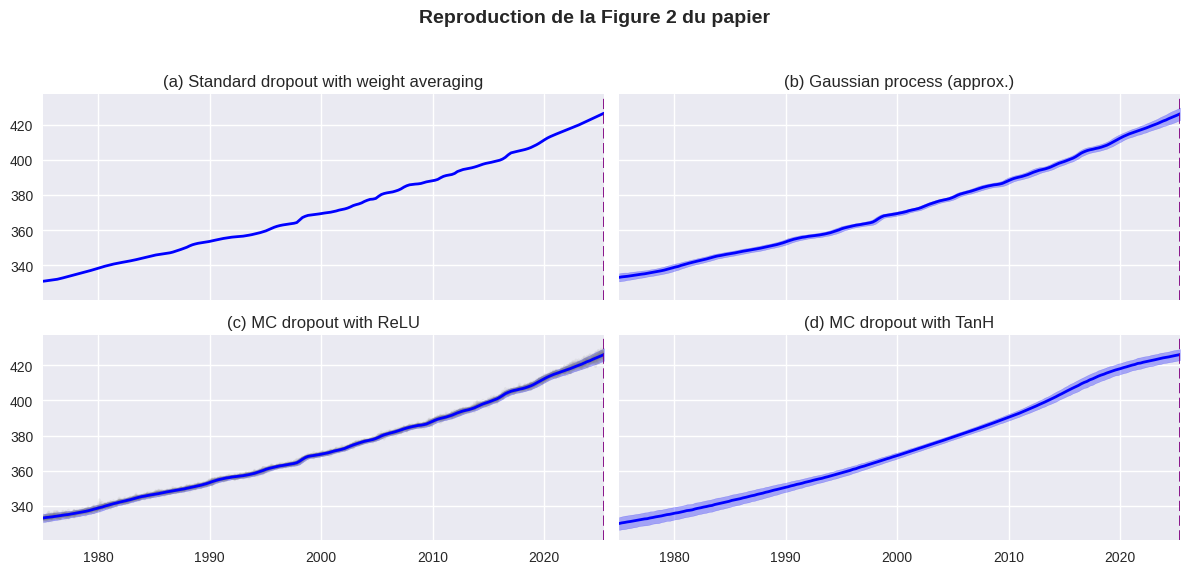

In [ ]:
import matplotlib.pyplot as plt

X_all_inv = scaler_X.inverse_transform(X_all).flatten()
y_pred_std_orig = y_pred_std_orig.flatten()
mean_relu_orig = mean_relu_orig.flatten()
std_relu_orig = std_relu_orig.flatten()
mean_tanh_orig = mean_tanh_orig.flatten()
std_tanh_orig = std_tanh_orig.flatten()

x_sep = scaler_X.inverse_transform([[X_train.max()]])[0][0]

preds_relu_samples = preds_relu[:30]

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

axs[0, 0].plot(X_all_inv, y_pred_std_orig, 'b-', lw=2)
axs[0, 0].axvline(x=x_sep, color='purple', linestyle='--', linewidth=2)
axs[0, 0].set_title("(a) Standard dropout with weight averaging")

axs[0, 1].plot(X_all_inv, mean_relu_orig, 'b-', lw=2)
axs[0, 1].fill_between(X_all_inv,
                       mean_relu_orig - 2 * std_relu_orig,
                       mean_relu_orig + 2 * std_relu_orig,
                       alpha=0.3, color='blue')
axs[0, 1].axvline(x=x_sep, color='purple', linestyle='--', linewidth=2)
axs[0, 1].set_title("(b) Gaussian process (approx.)")

for i in range(preds_relu_samples.shape[0]):
    sample_pred = scaler_y.inverse_transform(preds_relu_samples[i].reshape(-1, 1)).flatten()
    axs[1, 0].plot(X_all_inv, sample_pred, color='gray', alpha=0.1)
axs[1, 0].plot(X_all_inv, mean_relu_orig, 'b-', lw=2)
axs[1, 0].fill_between(X_all_inv,
                       mean_relu_orig - 2 * std_relu_orig,
                       mean_relu_orig + 2 * std_relu_orig,
                       alpha=0.3, color='blue')
axs[1, 0].axvline(x=x_sep, color='purple', linestyle='--', linewidth=2)
axs[1, 0].set_title("(c) MC dropout with ReLU")

axs[1, 1].plot(X_all_inv, mean_tanh_orig, 'b-', lw=2)
axs[1, 1].fill_between(X_all_inv,
                       mean_tanh_orig - 2 * std_tanh_orig,
                       mean_tanh_orig + 2 * std_tanh_orig,
                       alpha=0.3, color='blue')
axs[1, 1].axvline(x=x_sep, color='purple', linestyle='--', linewidth=2)
axs[1, 1].set_title("(d) MC dropout with TanH")

for ax in axs.flat:
    ax.set_ylim(df["CO2"].min() - 10, df["CO2"].max() + 10)
    ax.set_xlim(X_all_inv.min(), X_all_inv.max())
    ax.grid(True)
    ax.label_outer()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Part 2 – MC Dropout Classification


In [ ]:
# 📦 Block 8 - Import MNIST
from tensorflow.keras.datasets import mnist
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_train_mnist = X_train_mnist.astype("float32") / 255.0
X_test_mnist = X_test_mnist.astype("float32") / 255.0

X_train_mnist = np.expand_dims(X_train_mnist, -1)
X_test_mnist = np.expand_dims(X_test_mnist, -1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 🧠 Block 9 - CNN with Active Dropout
def build_lenet(dropout_rate=0.5):
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x, training=True)
    outputs = layers.Dense(10, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
# 🔁 Block 10 - Model Training
model_mnist = build_lenet()
model_mnist.fit(X_train_mnist, y_train_mnist, epochs=5, batch_size=128, verbose=1,
                validation_split=0.1)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.7952 - loss: 0.6567 - val_accuracy: 0.9817 - val_loss: 0.0662
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.9655 - loss: 0.1134 - val_accuracy: 0.9852 - val_loss: 0.0526
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.9774 - loss: 0.0789 - val_accuracy: 0.9882 - val_loss: 0.0423
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9801 - loss: 0.0630 - val_accuracy: 0.9895 - val_loss: 0.0367
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9837 - loss: 0.0538 - val_accuracy: 0.9905 - val_loss: 0.0349


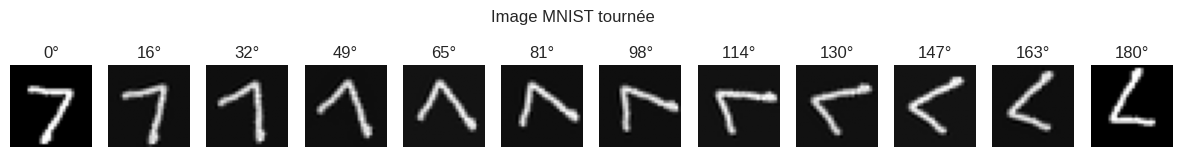

In [ ]:
# 📊 Block 11 - MC Dropout on Rotated Image
import scipy.ndimage

img = X_test_mnist[0]
angles = np.linspace(0, 180, 12)
plt.figure(figsize=(15, 2))

for i, angle in enumerate(angles):
    rotated = scipy.ndimage.rotate(img, angle, reshape=False)
    plt.subplot(1, 12, i+1)
    plt.imshow(rotated.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"{int(angle)}°")
plt.suptitle("Rotated MNIST Image")
plt.show()


In [ ]:
# 🔁 Block 12 - Uncertain Predictions with MC Dropout
rotated_images = [scipy.ndimage.rotate(img, angle, reshape=False) for angle in angles]
rotated_images = np.array(rotated_images).reshape(-1, 28, 28, 1)

def mc_classify(model, x, T=100):
    preds = np.array([model(x, training=True).numpy() for _ in range(T)])
    mean_pred = preds.mean(axis=0)
    std_pred = preds.std(axis=0)
    return mean_pred, std_pred

mean_preds, std_preds = mc_classify(model_mnist, rotated_images)

for i, (mean, std) in enumerate(zip(mean_preds, std_preds)):
    top = np.argmax(mean)
    print(f"Angle {int(angles[i])}°: Predicted class = {top}, Uncertainty = {std[top]:.4f}")


Angle 0°: Classe prédite = 7, Incertitude = 0.0011
Angle 16°: Classe prédite = 7, Incertitude = 0.0013
Angle 32°: Classe prédite = 7, Incertitude = 0.0884
Angle 49°: Classe prédite = 2, Incertitude = 0.3173
Angle 65°: Classe prédite = 7, Incertitude = 0.3011
Angle 81°: Classe prédite = 7, Incertitude = 0.3195
Angle 98°: Classe prédite = 5, Incertitude = 0.3323
Angle 114°: Classe prédite = 5, Incertitude = 0.3090
Angle 130°: Classe prédite = 5, Incertitude = 0.0999
Angle 147°: Classe prédite = 5, Incertitude = 0.1303
Angle 163°: Classe prédite = 6, Incertitude = 0.2737
Angle 180°: Classe prédite = 6, Incertitude = 0.3427


In [ ]:
# 🔍 Block 13 - MC Classify Logits and Probabilities
def mc_classify_logits_and_probs(model, x, T=100):
    logits_list = []
    probs_list = []
    f_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-1].input)
    for _ in range(T):
        logits_out = f_model(x, training=True).numpy()
        probs_out = tf.nn.softmax(logits_out).numpy()
        logits_list.append(logits_out)
        probs_list.append(probs_out)
    return np.array(logits_list), np.array(probs_list)


In [ ]:
# 🎯 Block 14 - Analyze Top Predicted Digits from MC Dropout
logits, probs = mc_classify_logits_and_probs(model_mnist, rotated_images, T=100)
mean_probs = probs.mean(axis=0)
top_classes = np.argmax(mean_probs, axis=1)

# Find the top 3 predicted digits across all angles (e.g., [1, 5, 7])
unique_preds = np.unique(top_classes)
# If more than 3, take the most frequent 3
from collections import Counter
top3_digits = [x for x, _ in Counter(top_classes).most_common(3)]
colors = {top3_digits[0]: 'green', top3_digits[1]: 'blue', top3_digits[2]: 'orange'}


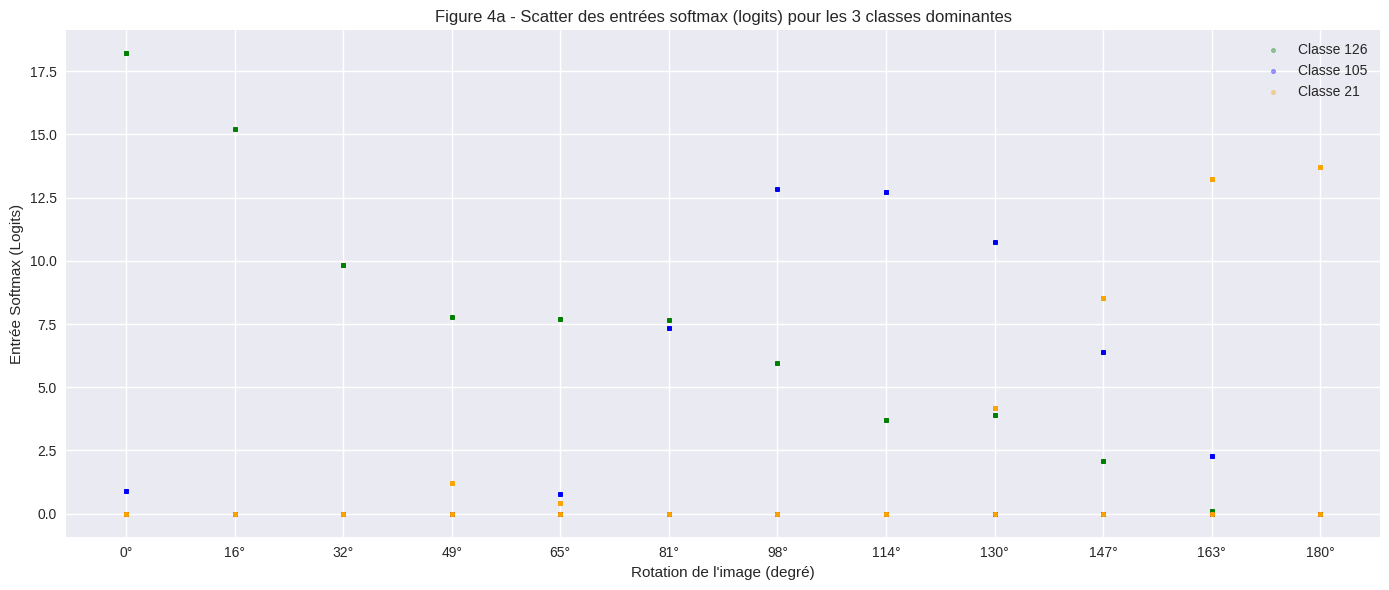

In [ ]:
plt.figure(figsize=(14, 6))
for angle_idx in range(len(angles)):
    for digit in top3_digits:
        # Get the 100 softmax input samples for this digit at this angle
        y_vals = logits[:, angle_idx, digit]
        x_vals = [angle_idx] * len(y_vals)
        plt.scatter(x_vals, y_vals, color=colors[digit], alpha=0.4, s=10,
                    label=f"Class {digit}" if angle_idx == 0 else "")
plt.xticks(np.arange(len(angles)), [f"{int(a)}°" for a in angles])
plt.xlabel("Image Rotation (degrees)")
plt.ylabel("Softmax Input (Logits)")
plt.title("Figure 4a - Scatter plot of softmax inputs (logits) for top 3 dominant classes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


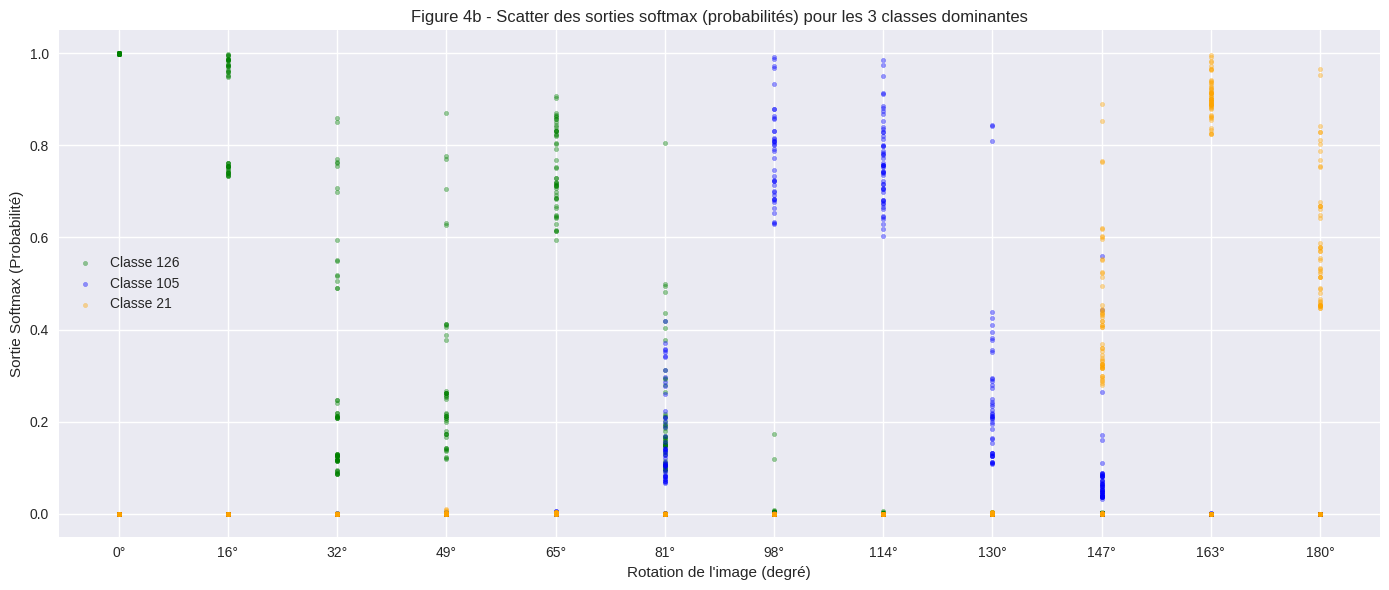

In [ ]:
plt.figure(figsize=(14, 6))
for angle_idx in range(len(angles)):
    for digit in top3_digits:
        y_vals = probs[:, angle_idx, digit]
        x_vals = [angle_idx] * len(y_vals)
        plt.scatter(x_vals, y_vals, color=colors[digit], alpha=0.4, s=10,
                    label=f"Class {digit}" if angle_idx == 0 else "")
plt.xticks(np.arange(len(angles)), [f"{int(a)}°" for a in angles])
plt.xlabel("Image Rotation (degrees)")
plt.ylabel("Softmax Output (Probability)")
plt.title("Figure 4b - Scatter plot of softmax outputs (probabilities) for top 3 dominant classes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 📚 Block 17 - Import Required Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, log_loss


In [ ]:
# 🏗️ Block 18 - MC Dropout Custom Model Definition
class MCDropoutModel(keras.Model):
    def __init__(self, input_dim, hidden_units=50, dropout_rate=0.05):
        super().__init__()
        self.hidden = layers.Dense(hidden_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.output_layer = layers.Dense(1)

    def call(self, x, training=False):
        x = self.hidden(x)
        x = self.dropout(x, training=training)  # Always dropout if training=True
        return self.output_layer(x)


In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, tau=1.0,
                       dropout_rate=0.05, num_samples=100):

    input_dim = X_train.shape[1]
    model = MCDropoutModel(input_dim, dropout_rate=dropout_rate)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss='mse')

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # MC forward passes
    preds = np.array([
        model(X_test, training=True).numpy().squeeze()
        for _ in range(num_samples)
    ])

    pred_mean = preds.mean(axis=0)
    pred_std = preds.std(axis=0)

    rmse = np.sqrt(mean_squared_error(y_test, pred_mean))

    # Log likelihood under Gaussian assumption
    ll = -0.5 * np.log(2 * np.pi * (pred_std ** 2)) - 0.5 * ((y_test - pred_mean) ** 2) / (pred_std ** 2)
    log_likelihood = np.mean(ll)

    return rmse, log_likelihood


In [ ]:
# 🏠 Block 20 - Load Ames Housing Dataset and Train MC Dropout Model
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Fetch the Ames Housing dataset
housing = fetch_openml(name="house_prices", as_frame=True)

# Drop non-numeric columns and the ID column
X = housing.data.select_dtypes(include=[np.number]).drop(columns=["Id"])
y = housing.target.astype(np.float32)

# Drop rows with missing values (simplest cleaning)
X = X.dropna()
y = y.loc[X.index]

# Standardize features
X = StandardScaler().fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate your MC Dropout model
rmse, ll = train_and_evaluate(X_train, y_train, X_test, y_test)
print(f"RMSE: {rmse:.2f}, Predictive LL: {ll:.2f}")


RMSE: 78577.24, Predictive LL: -5034.33
